Data Source: https://www.kaggle.com/shwetabh123/mall-customers

### Important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree,cophenet
from sklearn.metrics.pairwise import euclidean_distances
import plusmodules as pm

### Loading the data

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df = df.rename(columns={'Genre':'Gender'})
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

### Statistical summary of the features

In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Checking for missing values


In [6]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### Scaling of the data

In any algorithm that involves distance calculation, scaling is required.

In [7]:
cl=df[["Annual Income (k$)","Spending Score (1-100)"]]
ss=StandardScaler()
cls=ss.fit_transform(cl)
cls=pd.DataFrame(cls,columns=cl.columns)

### Dendrogram's  for different linkage methods

Similarity between the clusters (inter-cluster distance) can be measured using various types of linkages 

Some of the types are:  

**Single:** It is defined as the minimum distance between the points of two clusters. 

**Complete:** It is defined as the maximum distance between the points of the two different clusters 

**Average:** It is defined as the average of all the pairwise distances between the two clusters 

**Centroid linkage:** It is defined as the distance between the centroids (means) of the two clusters. 

**Ward Linkage (ward minimum variance method):** Rather than measuring distance directly, it examines cluster variance. Ward's method is said to be the best for quantitative variables.

Linkage method : single


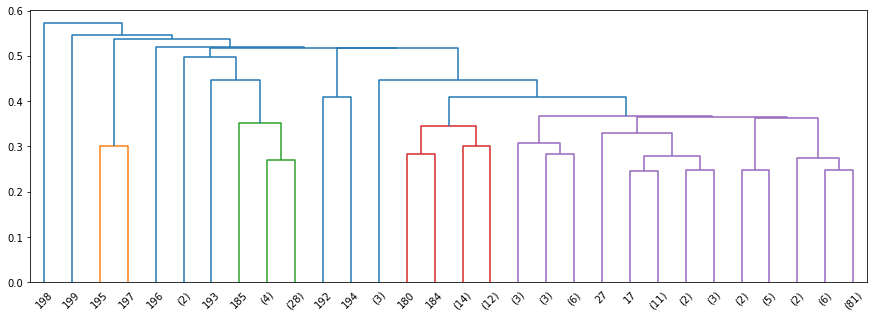

Linkage method : ward


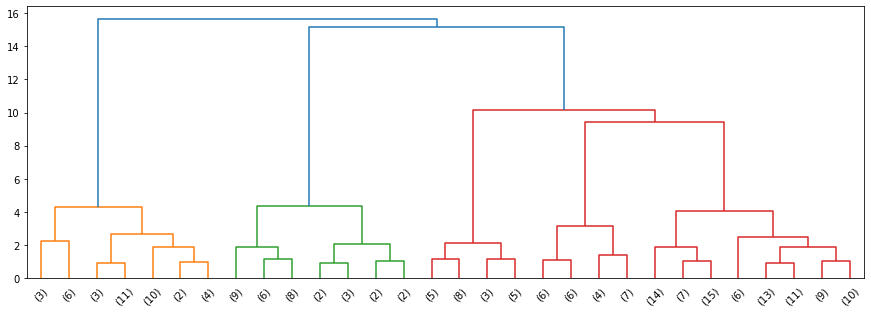

Linkage method : complete


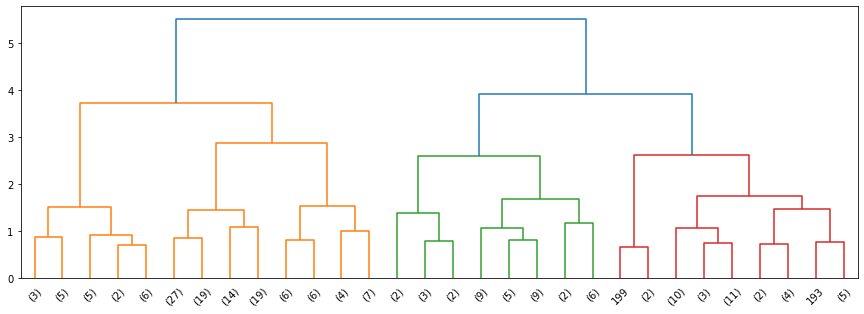

Linkage method : average


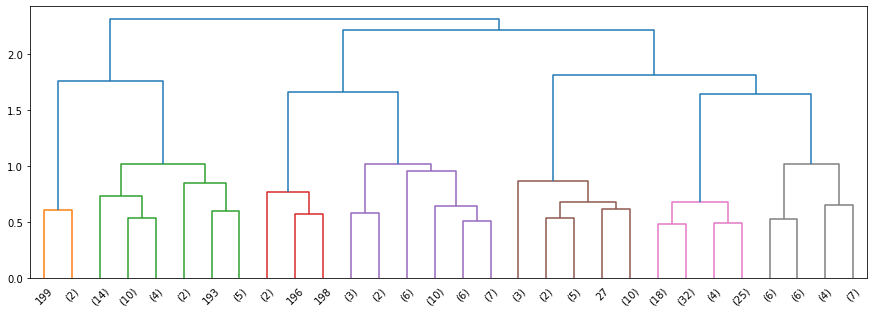

Linkage method : centroid


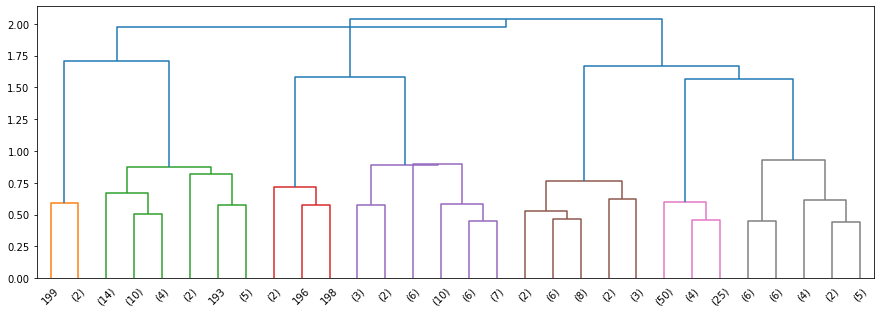

In [8]:
cophen=pd.DataFrame(columns=["Method","Cophen coeff"])
for i in ['single','ward','complete','average','centroid']:
    plt.figure(figsize=(15,5))
    print("Linkage method :",i)    
    eucli_dist = euclidean_distances(cls)
    dist_array = eucli_dist[np.triu_indices(200, k = 1)]
    mergings=linkage(cls,method=i)
    coeff, cophenet_dist=cophenet(mergings,dist_array)
    cophen=cophen.append({"Method":i,"Cophen coeff":coeff},ignore_index=True)
    #print("Cophenet coeff",coeff)
    
    dendrogram(mergings,truncate_mode='lastp')
    plt.show()

### Cophenetic Coefficients

* Cophenetic coefficients is the correlation betwteen cophenetic distances and the actual distance between the observations
* It measures how well the dendrogram represented the differences between the observations.
* The value close to 1 represents the best linkage quality 

In [9]:
cophen.sort_values(by='Cophen coeff',ascending=False)

,Method,Cophen coeff
0,single,0.721888
3,average,0.721728
1,ward,0.720913
4,centroid,0.717398
2,complete,0.666984


### Silhouette Score

The Silhouette score can also be used to determine the best cluster size. For various K values, we plot the Silhouette score. The K with the best Silhouette score represents the best number of clusters to use (K).

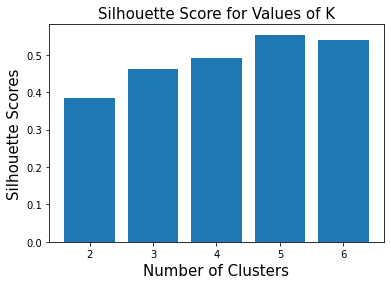

In [10]:
K = [2,3,4,5,6]
silhouette_scores = [] 
for i in K:
    model = AgglomerativeClustering(n_clusters = i) 
    silhouette_scores.append(silhouette_score(cls, model.fit_predict(cls)))  
plt.bar(K, silhouette_scores) 
plt.title('Silhouette Score for Values of K', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 15) 
plt.ylabel('Silhouette Scores', fontsize = 15)
plt.show()

The Silhouette score for K = 5 is the highest, as shown in the graph above. This implies that K = 5 is the best number of clusters to use.

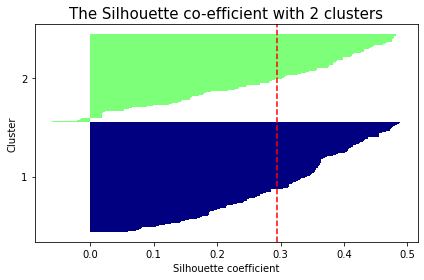

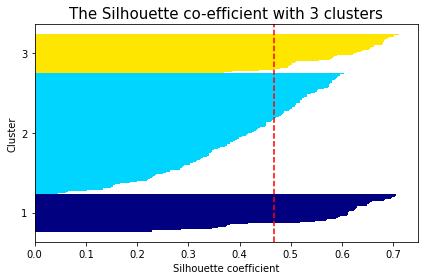

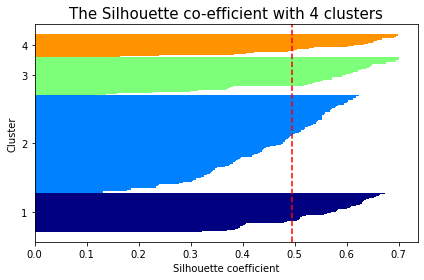

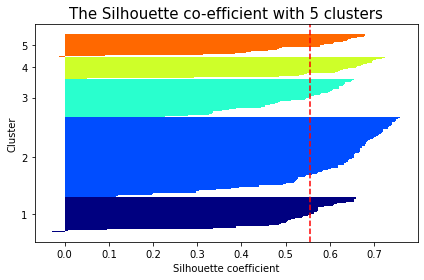

In [11]:
for i in range(2,6):
    plt.title(f"The Silhouette co-efficient with {i} clusters",fontsize = 15)
    pm.svisualizer(cls, i)

We should choose four clusters based on the plots above as there are no outliers, but we'll go with five.

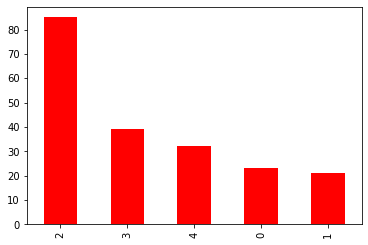

In [12]:
mergings=linkage(cls,method='ward')
clustercut = pd.Series(cut_tree(mergings, n_clusters=5).reshape(-1,))
clustercut.value_counts().plot(kind='bar',color='r');

In [13]:
cl = cl.copy()
cl['cluster'] = clustercut

### Mean of the clusters after segmentation

In [14]:
cl.groupby('cluster').agg('mean')

,Annual Income (k$),Spending Score (1-100)
cluster,,
0,26.304348,20.913043
1,25.095238,80.047619
2,55.811765,49.129412
3,86.538462,82.128205
4,89.406250,15.593750


**Cluster 0:** This cluster's annual income is lower, and their spending score is lower than their annual income.

**Clusert 1:** Despite having a low annual income, the spending score is high.

**Cluster 2:** With a medium income and a medium level of spending.

**Cluster 3:** Class of people with high income and high spending score

**Cluster 4:** Even though the conservative class has a high income, they spend very little.

### Visualization of clusters

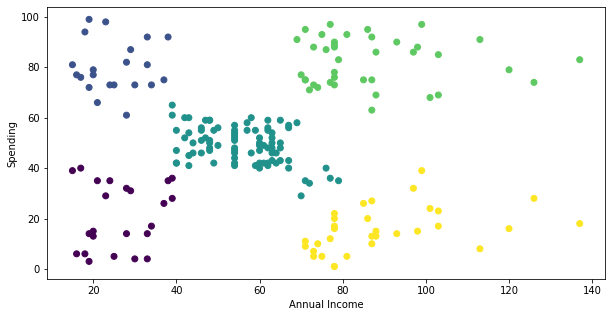

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(cl['Annual Income (k$)'], cl['Spending Score (1-100)'], c=cl['cluster'])
plt.xlabel('Annual Income')
plt.ylabel('Spending')
plt.show()